# An applied tutorial on Principal Component Analysis (PCA) 
##  A step-by-step guide on PCA and extracting "Eigenfaces"[(1)] using python in the context of a face recognition system

Principal component analysis (PCA) is a statistical method which uses orthogonal linear projections onto a often lower dimensional subspace. These uncorrelated projections are called principal components. PCA is wildly uses in data analysis, machine learning and data compression.

## Introduction

We are interested in finding an "meaningful" projection of our D-dimensional data onto a low dimensional subspace with losing as little information as possible. For simplicity reasons image we want to project our data onto a one-dimensional subspace. In other words: we want to project our data onto a line which describes the data as good as possible.

Lets visualize this in python using random data. Therefore we generate two-dimensional data points using a bivariate gaussian as shown below.
[(1)]:https://www.cs.princeton.edu/~cdecoro/eigenfaces/

[-3, 3, -3, 3]

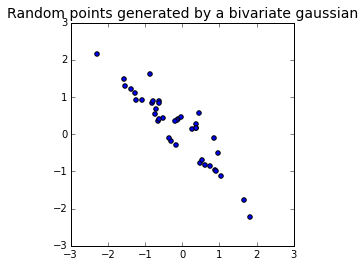

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA
import os,sys
from PIL import Image

# define mean vector and variance-covariance matrix for 
# the bivariate gaussian
mu = np.array([0,0])
sigma = np.array([[1.0,-0.95],[-0.95,1.0]]) 

# draw 40 random samples from the distribution specified above
np.random.seed(76778)
data = np.random.multivariate_normal(mu, sigma, 40) 

# plot the result in a scatter plot
plt.scatter(data[:,0],data[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Random points generated by a bivariate gaussian", size=14)
plt.axis([-3,3,-3,3])

## Finding the first principal component
Lets image we want to project the data above onto a one-dimensional line such that we preserve as much information as possible. The following plot shows two possibilities for such lines and their corresponding projections in red and green. It is easy to see that the projection onto the green line generalizes the data much better than the projection onto the red line. This is because the projection preserves more variability as seen in the right plot, while when we project onto the red line this variability gets lost.

(-4.0, 4.0, -0.15000000000000002, 0.15000000000000002)

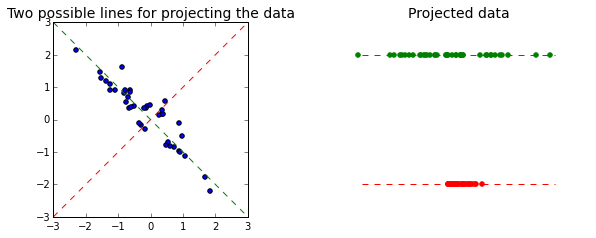

In [6]:
# vector u describes the red line 
# vector v describes the green line
u = np.ones(2)/LA.norm(np.ones(2))
v = np.array([1,-1])/LA.norm(np.array([1,-1]))

# project data on u and v
data_u = u.dot(data.T)
data_v = v.dot(data.T)


# plot the result in a scatter plot
plt.figure(figsize=(8, 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# first plot plots the data points and lines for projection 
plt.subplot(1, 2, 1)
plt.scatter(data[:,0],data[:,1])
plt.axis([-3,3,-3,3])
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([-3,+3], [-3,+3], 'k--',color='r')
plt.plot([-3, 3], [3, -3], 'k--',color='g')
plt.title("Two possible lines for projecting the data", size=14)

# second plot plots the projected data
plt.subplot(1, 2, 2)
plt.scatter(data_u, np.zeros_like(data_u)-0.1,color='r')
plt.plot([-3,+3], [-.1,-.1], 'k--',color='r')
plt.scatter(data_v, np.zeros_like(data_v)+.1,color='g')
plt.plot([-3,+3], [.1,.1], 'k--',color='g')
plt.title("Projected data", size=14)
plt.axis('off')


Lets formalize this knowledge: We are searching for a linear transformation onto a one dimensional line which maximizes the variance in the data. We can describe such a transformation by a single vector $u$ representing the line. For mathematical convenience let $u$ be a unit vector having a euclidean norm of one.

Variance in our data can be represented by the variance-covariance matrix $\Sigma$ which is defined as follows:

$\Sigma = \frac{1}{N} \sum_{n=1}^{N} (x_n-\bar{x})(x_n-\bar{x})^T$

Due to the linearity of the mean, the mean of our projected data is equal to the linear transformation of the sample mean. Thus the projected mean is $u^T\bar{x}$

Therefore the mean of the projected data can be computed like follows: 

$\frac{1}{N} \sum_{n=1}^{N} (u^Tx_n-u^T\bar{x})(u^Tx_n-u^T\bar{x})^T$ because the transformation is linear we can also write 

$\frac{1}{N} \sum_{n=1}^{N} u^T(x_n-\bar{x})(x_n-\bar{x})^Tu$ the sum does not depend on $u$ therefore the variance of the projected data is equal to:

$u^T\Sigma u$


Formally speaking we are searching a hyperplane vector $u$ that maximizes $u^t\Sigma u$ such that $||u||=1$. This leaves us with a constrained optimization problem, which we can sole by using the Lagrangian:
$\mathcal{L} := u^T\Sigma u + \lambda_1(1-u^Tu)$

To get the maximum we simply set the derivative to zero

$\frac{\partial \mathcal{L}}{\partial u} = 2\Sigma u - \lambda_1u \stackrel{!}{=}
 0$

which leaves us with 

$\Sigma u = \lambda_1 u$

This is a really nice formula which tells us that $u$ is a eigenvector of the covariance matrix $\Sigma$ and the Lagrangian multiplier $\lambda_1$ is its associated eigenvalue. Thus we can reformulate the statement as $\lambda_1 = u^T\Sigma u$. Therefore $\lambda_1$ is not only the eigenvalue associated with $u$ its also the variance of the projected data. 

To maximize the variance we therefore hav to find the eigenvector with the largest associated eigenvalue (= largest variance after using the eigenvector for projection). The eigenvector $u$ with the largest associated eigenvalue equals therefore the first principal direction.


## Finding further principal components
Typically using only one principal component is not sufficient, since using only one dimension does not represent data well enough. Therefore in PCA we typically want to find k principal components where k has to be less or equal D (dimensionality of the data). Above we showed how to find the first principal component. Each following component $u_i$ has to maximize the variance under the constraint that it is orthogonal to all other principal components $u_j$ where $j<i$. 
It is easy to show that we can do this by sorting the eigenvectors of $\Sigma$ according to their eigenvalues and choosing the eigenvector associated with the ith-largest eigenvalue as the ith principal component. (NOTE: Eigenvectors of a symmetric matrix corresponding to different eigenvalues will always be orthogonal.)

# Extracting “Eigenfaces” from image data using PCA
In the following we want to show a more practical use case. In the beginning we apply PCA step by step to image data in plain python (NOTE: In practice libraries like scikit learn should be used rather than self developed solutions). We apply PCA for the particular application of extracting eigenfaces (set of eigenvectors - extracted from images containing human faces). The term eigenfaces goes back to a research on on face recognition at the University of Princeton (https://www.cs.princeton.edu/~cdecoro/eigenfaces/). After applying PCA we will show the main benefits of this method in the terms of compressing pictures.

The original dataset is available here: http://www.cs.princeton.edu/courses/archive/spr04/cos429/images/yalefaces.zip
Whereas for this assignment the following set was used https://github.com/dalab/lecture_cil_public/tree/master/exercises/ex2  

### Load Image data

In [7]:
# Load data
image_dir = "CroppedYale/"
files = os.listdir(image_dir)
datarows = len(files)
imgs = [Image.open(image_dir + files[i]) for i in xrange(datarows)]

Now we want to transform the images into a matrix consisting of numerical data. At the moment we don't care about the exact representation of our images, as long as they are all of the same format. We are transforming each of the Images into an (width*hight)-dimensional vector where each component represents one pixel of the image. All those vectors are then combined into an matrix $X$ representing our dataset. As we can see below the Matrix contains of 38 rows (pictures), each of them described by an 4080-dimensional feature vector.

In [8]:
# Assume all images have the same size
img0 = imgs[0]
width, height = img0.size
datadimension = width*height

# Compute input matrix X
X_list = [np.reshape(imgs[i].getdata(), (datadimension)) for i in xrange(datarows)]
X = np.array(X_list)

# assert we did load the data correctly
assert X.shape[0]==datarows
assert X.shape[1]==datadimension

# output the shape of the matrix
print X.shape

(38, 4080)


###  Normalize data
In a next step we want our data to have zero mean. Therefore we have to calculate the mean vector and subtract it from our original matrix. The mean vector is a 4080-dimensional vector representing the mean value for each of the 4080 dimensions. This makes the calculation of the covariance matrix much more easy since we don't have to subtract the mean in every step. Recall the formula for the covariance matrix was: 

$\Sigma = \frac{1}{N} \sum_{n=1}^{N} (x_n-\bar{x})(x_n-\bar{x})^T$

Using centered data ($\bar{x}=0$) we can rewrite this as: 

$\Sigma = \frac{1}{N} \sum_{n=1}^{N} x_nx_n^T$



In [9]:
x_mean = np.mean(X,axis=0)
X_centered = (X - x_mean)

### Compute variance-covariance matrix
Note that sigma is a 4080 x 4080 dimensional symmetric matrix.

In [10]:
sigma = X_centered.T.dot(X_centered)/datarows
print sigma.shape

# an alternative (though less efficient) way to implement 
# this is the following:

# sigma = np.zeros((datadimension,datadimension))
# for i in range(datarows):
#     sigma += np.outer(X_centered[i,:],X_centered[i,:])   
# sigma /= datarows

(4080, 4080)


### Compute Eigenvectors and corresponding Eigenvalues
For computing the eigenvectors and their corresponding eigenvalues we use the ‘eig’ method of numpy's linear algebra package. Note that those values are not necessarily sorted.

In [11]:
# compute eigenvectors and eigenvalues of sigma
eigenValues, eigenVectors = LA.eig(sigma)
# discard imaginary part
eigenValues = np.real(eigenValues)
eigenVectors = np.real(eigenVectors)

# sort eigenvalues according to the size
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
# sort eigenvectors according to their eigenvalues
eigenVectors = eigenVectors[:,idx]

### The "Eigenspectrum"
The following plot shows the first 100 biggest eigenvalues of our data plotted on the y axis. As we can see this curve drops rapidly. Recall that an eigenvalue represents the variance of the projected data. This knee in the curve is very strong evidence that we should be able to represent our data in a much lower dimensional space (15 instead of 4080 dimensions) without loosing much information. We will come back to this later.

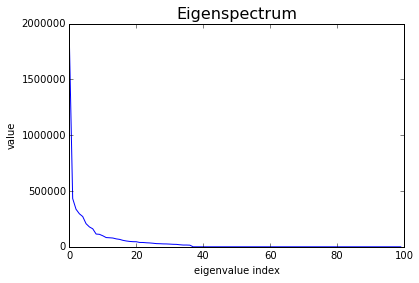

In [12]:
plt.plot(range(0, 100), eigenValues[:100])
ax = plt.gca()
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("value")
ax.set_title("Eigenspectrum", size=16)

### Visualizing the first eigenvector (eigenface)
The following image visualizes the first eigenvector and the result is really amazing in a beautiful way. But what does this ghost-like face stand for? The blurred nose might center the nose when applying it to a picture - like a transformation to the left. Typically those eigenvectors will shift and rotate the original images into a new coordinate system in which tasks like face recognition are far more efficient as described in https://www.cs.princeton.edu/~cdecoro/eigenfaces/

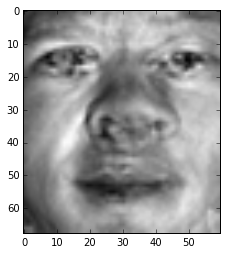

In [13]:
pc1 = eigenVectors[:,0]
pc1 = pc1.reshape(height,width)


plt.imshow(pc1.reshape((height, width)), cmap=plt.cm.gray)
#plt.title("$\lambda_{1}$", size=24)


### Using PCA for compression 
As mentioned before the eigenspectrum shows that most of the variability in the data can be preserved by using only very view dimensions. In the following we will show that the 4080-dimensional images can be represented accurately by using only 15 dimensions. This equals an impressive compression ratio of 272!

If we want to transform (compress) our data onto a k dimensional subspace we simply combine the k eigenvectors with the highest associated eigenvalues to a transformation matrix. After subtracting the mean of the original image we multiply the picture by our transformation matrix. To reconstruct the image we have to multiply it again with our transformation matrix and add the mean afterwards.

In the following python example we are showing one of the original pictures (4080 pixels). Next to it we are showing compressed versions of the picture which are using 5, 10 and 15 pixels for storage. As already intended by the eigenspectrum above we can see that the quality converges very fast towards the original image. Therefore by only storing the sample mean vector $\bar{x}$ and the transformation matrix we can store all our pictures with immense compression rates.

compressed image using 5 dimensions
compressed image using 10 dimensions
compressed image using 15 dimensions


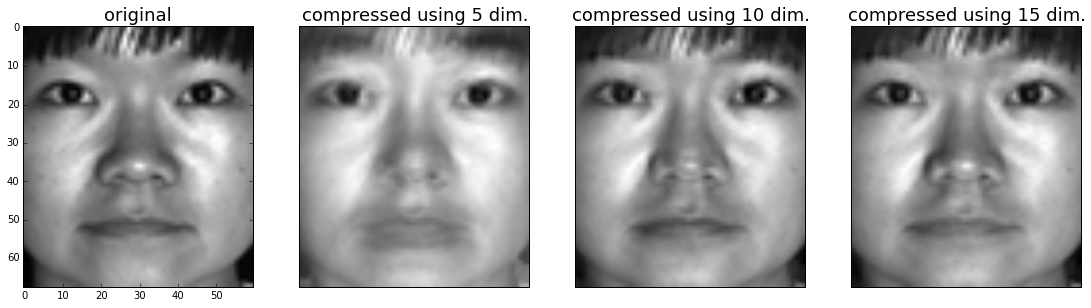

In [14]:
image_original= X[4,:]

# adjust plot
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# plot originial 
plt.subplot(1, 4, 1)   
plt.imshow(image_original.reshape((height, width)), cmap=plt.cm.gray)
plt.title("original",size=18)

# use 5, 10, and 15 principal components compress picture
# and plot the reconstructed version
for i in range(3):
    transformation_matrix = eigenVectors[:,:(i+1)*5]
    # compress image
    image_compressed = (image_original-x_mean).dot(transformation_matrix)
    # reconstruct image
    image_reconstructed = transformation_matrix.dot(image_compressed)+x_mean
    
    print ("compressed image using %d dimensions" % image_compressed.shape[0])
    
    # plot reconstructed image
    sub = plt.subplot(1, 4, i + 2)   
    plt.imshow(image_reconstructed.reshape((height, width)), cmap=plt.cm.gray)
    plt.title("compressed using %d dim." % ((i + 1)*5), size=18)
    plt.xticks(())
    plt.yticks(())


# Acknowledgements

Tutorial written by Bernhard Kratzwald. 

Based on https://www.cs.princeton.edu/~cdecoro/eigenfaces/ and an assignment in the course Computational Intelligence Lab of ETH Zürich: http://cil.inf.ethz.ch

Questions, comments, wishes, complaints: bernhard2202 [at] gmail [dot] com
